<a href="https://colab.research.google.com/github/alitheonly/PlantSeedling-/blob/main/0_5_Drop_Adam_All_B64_0214.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
uploaded = files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c plant-seedlings-classification
!unzip plant-seedlings-classification.zip

Streaming output truncated to the last 5000 lines.
  inflating: test/ad12382d4.png      
  inflating: test/adb7a032c.png      
  inflating: test/ae90f2827.png      
  inflating: test/aecfaed64.png      
  inflating: test/aee6fa3df.png      
  inflating: test/af45e222a.png      
  inflating: test/afa446484.png      
  inflating: test/afcf6abd5.png      
  inflating: test/b026bf8ca.png      
  inflating: test/b03397525.png      
  inflating: test/b0acaff4a.png      
  inflating: test/b130a0632.png      
  inflating: test/b145ba9d4.png      
  inflating: test/b1cd2a91e.png      
  inflating: test/b215531dd.png      
  inflating: test/b2706e2b3.png      
  inflating: test/b29339405.png      
  inflating: test/b30ab4659.png      
  inflating: test/b31292706.png      
  inflating: test/b341d0aab.png      
  inflating: test/b39c71707.png      
  inflating: test/b3d6fdb80.png      
  inflating: test/b3e08b037.png      
  inflating: test/b47691c08.png      
  inflating: test/b4c3df835.png      

In [ ]:

# Import necessary libraries

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.optimizers import Adam
import tensorflow as tf
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import random
from glob import glob
import imageio

In [ ]:
!ls ../content/train

 Black-grass	    'Common wheat'	'Scentless Mayweed'
 Charlock	    'Fat Hen'		'Shepherds Purse'
 Cleavers	    'Loose Silky-bent'	'Small-flowered Cranesbill'
'Common Chickweed'   Maize		'Sugar beet'


In [ ]:
data_path = '/content/'
train_dir = os.path.join(data_path,'train')
test_dir = os.path.join(data_path, 'test')

In [ ]:
images_path= '/content/train/*/*.png'
images = glob(images_path)

img_size = 224
train_images = []
train_labels = []
for i in images:
    train_images.append(cv2.resize(cv2.imread(i), (img_size, img_size))) 
    train_labels.append(i.split('/')[-2])
train_X = np.asarray(train_images)
train_Y = pd.DataFrame(train_labels)

In [ ]:
train_X

array([[[[ 54,  65,  81],
         [ 51,  60,  77],
         [ 38,  50,  71],
         ...,
         [ 70,  93, 106],
         [ 66,  87, 105],
         [ 60,  82, 105]],

        [[ 59,  67,  81],
         [ 54,  63,  78],
         [ 52,  60,  77],
         ...,
         [ 75,  91, 103],
         [ 78,  95, 108],
         [ 71,  87, 105]],

        [[ 76,  82,  98],
         [ 73,  80,  96],
         [ 55,  64,  82],
         ...,
         [ 75,  94, 107],
         [ 75,  95, 106],
         [ 80, 100, 111]],

        ...,

        [[ 61,  64,  72],
         [ 64,  65,  73],
         [ 68,  71,  79],
         ...,
         [ 71,  83, 101],
         [ 67,  81,  95],
         [ 68,  86, 102]],

        [[ 50,  51,  54],
         [ 52,  50,  54],
         [ 63,  60,  64],
         ...,
         [ 68,  80,  97],
         [ 81,  96, 106],
         [ 69,  87, 103]],

        [[ 51,  50,  53],
         [ 51,  49,  50],
         [ 62,  61,  64],
         ...,
         [ 68,  86,  99],
        

In [ ]:
train_Y

,0
0,Sugar beet
1,Sugar beet
2,Sugar beet
3,Sugar beet
4,Sugar beet
...,...
4745,Small-flowered Cranesbill
4746,Small-flowered Cranesbill
4747,Small-flowered Cranesbill
4748,Small-flowered Cranesbill


In [ ]:
train_Y.rename(columns={0:'species'},inplace=True)
_, train_count = np.unique(train_Y,return_counts=True)
df = pd.DataFrame(data = train_count)
a = train_Y['species'].unique()
a = a.tolist()
a.sort()
df['Index'] = a
df.columns = ['Train','Name']
df

,Train,Name
0,263,Black-grass
1,390,Charlock
2,287,Cleavers
3,611,Common Chickweed
4,221,Common wheat
5,475,Fat Hen
6,654,Loose Silky-bent
7,221,Maize
8,516,Scentless Mayweed
9,231,Shepherds Purse


In [ ]:
from sklearn.preprocessing import LabelBinarizer
y = LabelBinarizer().fit_transform(train_Y.species)
train_label = np.array(y,dtype=np.float32)
train_label

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.]], dtype=float32)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train_X, train_label,test_size=0.3,random_state=7)
print((X_train.shape,X_test.shape))

((3325, 224, 224, 3), (1425, 224, 224, 3))



**Image** Normalization




In [ ]:
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255 

## Image Data Generator

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
        rotation_range=180,  
        zoom_range = 0.1,
        width_shift_range=0.1,  
        height_shift_range=0.1,  
        horizontal_flip=True,  
        vertical_flip=True  
    )  
datagen.fit(train_X)

VGG Model

In [ ]:

from keras.applications.vgg16 import VGG16

# Instantiate a VGG16 model with pre-trained weights

base_model= VGG16(weights='imagenet',input_shape=(224, 224, 3),include_top=False)
base_model.trainable = False



58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.5)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model.save('VGG16_other_0129.h5')

In [ ]:
print(os.path.getsize("VGG16_other_0129.h5")/1048576, "MB")

58.25103759765625 MB


In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:

# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=64, validation_data=(X_test, y_test))#,callbacks = [early_stopping,checkpoint])

Epoch 1/25
52/52 [==============================] - 160s 3s/step - loss: 2.2264 - accuracy: 0.2370 - val_loss: 1.9622 - val_accuracy: 0.3572
Epoch 2/25
52/52 [==============================] - 159s 3s/step - loss: 1.9133 - accuracy: 0.3483 - val_loss: 1.7791 - val_accuracy: 0.4196
Epoch 3/25
52/52 [==============================] - 160s 3s/step - loss: 1.7594 - accuracy: 0.4015 - val_loss: 1.6823 - val_accuracy: 0.4407
Epoch 4/25
52/52 [==============================] - 159s 3s/step - loss: 1.6366 - accuracy: 0.4547 - val_loss: 1.5533 - val_accuracy: 0.4744
Epoch 5/25
52/52 [==============================] - 160s 3s/step - loss: 1.5460 - accuracy: 0.4824 - val_loss: 1.4544 - val_accuracy: 0.5242
Epoch 6/25
52/52 [==============================] - 160s 3s/step - loss: 1.4698 - accuracy: 0.4989 - val_loss: 1.3917 - val_accuracy: 0.5305
Epoch 7/25
52/52 [==============================] - 161s 3s/step - loss: 1.4158 - accuracy: 0.5128 - val_loss: 1.3750 - val_accuracy: 0.5375
Epoch 8/25
52

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model.save('VGG16_other_0129.h5')

In [ ]:
print(os.path.getsize("VGG16_other_0129.h5")/1048576, "MB")

62.37030792236328 MB


In [ ]:
#from google.colab import files
# model.save('Split Sklearn Train/Valid VGG16.h5')
#files.download('Split Sklearn Train/Valid VGG16.h5')

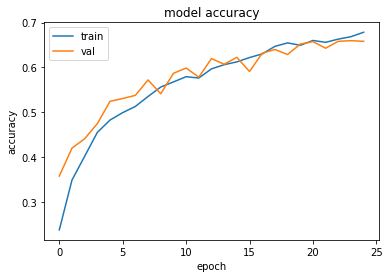

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

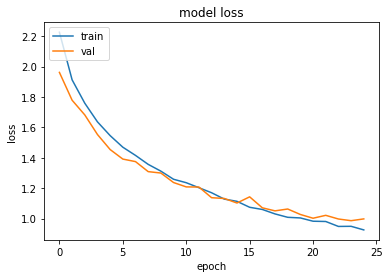

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
loss, acc = model.evaluate(X_test,y_test)
loss1, acc1 = model.evaluate(X_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)

104/104 [==============================] - 109s 1s/step - loss: 0.8496 - accuracy: 0.7050
Test loss: 0.9978975057601929    Test accuracy: 0.6582456231117249
Train loss: 0.8496246337890625    Train accuracy: 0.704962432384491


## Resnet 50

In [ ]:
from keras.applications import ResNet152V2
# Instantiate a ResNet50 model with pre-trained weights
base_model = ResNet152V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "resnet152v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                        

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.5)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.save('Resnet 50_0129.h5')
print(os.path.getsize("Resnet 50_0129.h5")/1048576, "MB")

232.04363250732422 MB


In [ ]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/25
52/52 [==============================] - 191s 4s/step - loss: 1.2817 - accuracy: 0.5862 - val_loss: 0.7093 - val_accuracy: 0.7825
Epoch 2/25
52/52 [==============================] - 179s 3s/step - loss: 0.5843 - accuracy: 0.8012 - val_loss: 0.5929 - val_accuracy: 0.8035
Epoch 3/25
52/52 [==============================] - 178s 3s/step - loss: 0.4358 - accuracy: 0.8514 - val_loss: 0.5501 - val_accuracy: 0.8168
Epoch 4/25
52/52 [==============================] - 186s 4s/step - loss: 0.3384 - accuracy: 0.8776 - val_loss: 0.5047 - val_accuracy: 0.8316
Epoch 5/25
52/52 [==============================] - 183s 4s/step - loss: 0.2719 - accuracy: 0.9110 - val_loss: 0.4653 - val_accuracy: 0.8414
Epoch 6/25
52/52 [==============================] - 183s 4s/step - loss: 0.2314 - accuracy: 0.9227 - val_loss: 0.4879 - val_accuracy: 0.8449
Epoch 7/25
52/52 [==============================] - 182s 4s/step - loss: 0.1906 - accuracy: 0.9371 - val_loss: 0.5169 - val_accuracy: 0.8344
Epoch 8/25
52

In [ ]:
model.save('Resnet 50_0129.h5')
print(os.path.getsize("Resnet 50_0129.h5")/1048576, "MB")

248.15567779541016 MB


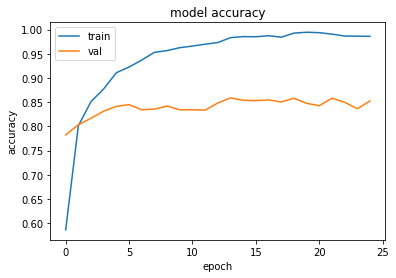

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


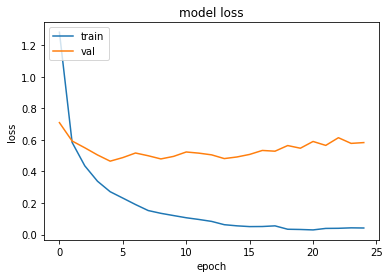

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


In [ ]:
loss, acc = model.evaluate(X_test,y_test)
loss1, acc1 = model.evaluate(X_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)


104/104 [==============================] - 110s 1s/step - loss: 0.0095 - accuracy: 0.9991
Test loss: 0.5829214453697205    Test accuracy: 0.8526315689086914
Train loss: 0.00946472305804491    Train accuracy: 0.9990977644920349


## INCEPTION V3

In [ ]:
from keras.applications import InceptionV3
# Instantiate a InceptionV3 model with pre-trained weights
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


87910968/87910968 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.5)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                           

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.save('INCEPTION_other_0129.h5')


print(os.path.getsize("INCEPTION_other_0129.h5")/1048576, "MB")


92.0603256225586 MB


In [ ]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/25
52/52 [==============================] - 41s 723ms/step - loss: 1.7228 - accuracy: 0.4782 - val_loss: 0.9345 - val_accuracy: 0.7018
Epoch 2/25
52/52 [==============================] - 35s 678ms/step - loss: 0.8776 - accuracy: 0.6971 - val_loss: 0.7756 - val_accuracy: 0.7354
Epoch 3/25
52/52 [==============================] - 35s 685ms/step - loss: 0.6939 - accuracy: 0.7588 - val_loss: 0.6972 - val_accuracy: 0.7656
Epoch 4/25
52/52 [==============================] - 35s 683ms/step - loss: 0.5930 - accuracy: 0.7913 - val_loss: 0.6476 - val_accuracy: 0.7902
Epoch 5/25
52/52 [==============================] - 35s 684ms/step - loss: 0.4967 - accuracy: 0.8217 - val_loss: 0.6581 - val_accuracy: 0.7895
Epoch 6/25
52/52 [==============================] - 35s 683ms/step - loss: 0.4609 - accuracy: 0.8364 - val_loss: 0.6347 - val_accuracy: 0.7979
Epoch 7/25
52/52 [==============================] - 35s 681ms/step - loss: 0.4056 - accuracy: 0.8586 - val_loss: 0.6104 - val_accuracy: 0.7993

In [ ]:
model.save('INCEPTION_other_0129.h5')


print(os.path.getsize("INCEPTION_other_0129.h5")/1048576, "MB")



108.17230224609375 MB


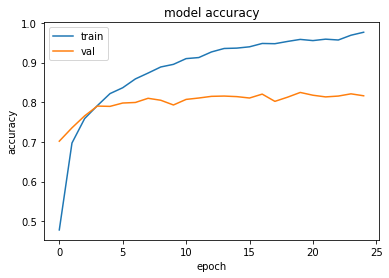

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


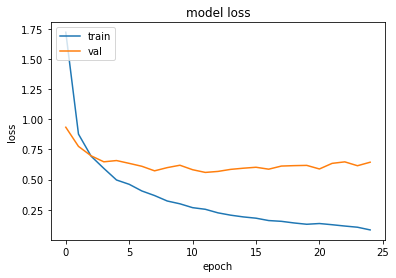

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



In [ ]:
loss, acc = model.evaluate(X_test,y_test)
loss1, acc1 = model.evaluate(X_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)


104/104 [==============================] - 24s 233ms/step - loss: 0.0278 - accuracy: 0.9979
Test loss: 0.6442161202430725    Test accuracy: 0.816140353679657
Train loss: 0.027846457436680794    Train accuracy: 0.9978947639465332


## XCEPTION

In [ ]:
from keras.applications import Xception
# Instantiate a Xception model with pre-trained weights
base_model = Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.5)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                           

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.save('XCEPTION_other_0129.h5')


print(os.path.getsize("XCEPTION_other_0129.h5")/1048576, "MB")


88.02407836914062 MB


In [ ]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/25
52/52 [==============================] - 89s 2s/step - loss: 1.3918 - accuracy: 0.5386 - val_loss: 0.9652 - val_accuracy: 0.6744
Epoch 2/25
52/52 [==============================] - 86s 2s/step - loss: 0.7873 - accuracy: 0.7347 - val_loss: 0.7516 - val_accuracy: 0.7537
Epoch 3/25
52/52 [==============================] - 88s 2s/step - loss: 0.6123 - accuracy: 0.7895 - val_loss: 0.6797 - val_accuracy: 0.7684
Epoch 4/25
52/52 [==============================] - 86s 2s/step - loss: 0.5015 - accuracy: 0.8322 - val_loss: 0.6401 - val_accuracy: 0.7881
Epoch 5/25
52/52 [==============================] - 84s 2s/step - loss: 0.4221 - accuracy: 0.8623 - val_loss: 0.6507 - val_accuracy: 0.7796
Epoch 6/25
52/52 [==============================] - 86s 2s/step - loss: 0.3664 - accuracy: 0.8764 - val_loss: 0.6131 - val_accuracy: 0.7923
Epoch 7/25
52/52 [==============================] - 86s 2s/step - loss: 0.3339 - accuracy: 0.8893 - val_loss: 0.6348 - val_accuracy: 0.7902
Epoch 8/25
52/52 [==

In [ ]:
model.save('XCEPTION_other_0129.h5')


print(os.path.getsize("XCEPTION_other_0129.h5")/1048576, "MB")



104.13621520996094 MB


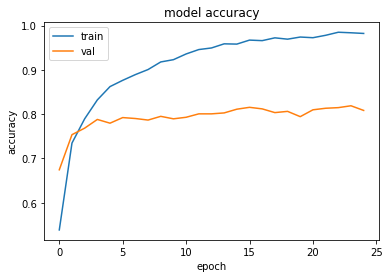

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


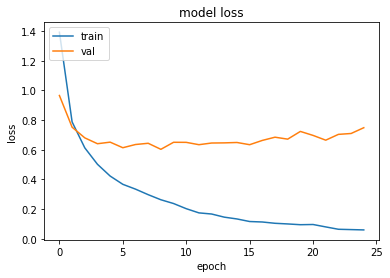

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



In [ ]:
loss, acc = model.evaluate(X_test,y_test)
loss1, acc1 = model.evaluate(X_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)


104/104 [==============================] - 51s 488ms/step - loss: 0.0291 - accuracy: 0.9961
Test loss: 0.748098611831665    Test accuracy: 0.8084210753440857
Train loss: 0.029131926596164703    Train accuracy: 0.9960902333259583


## **DenseNet121**

In [ ]:
from keras.applications import DenseNet121
# Instantiate a DenseNet121 model with pre-trained weights
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


29084464/29084464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_6[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                        

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.5)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_6[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                            

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.save('DenseNet121_other_0129.h5')


print(os.path.getsize("DenseNet121_other_0129.h5")/1048576, "MB")


32.02589416503906 MB


In [ ]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/25
52/52 [==============================] - 94s 2s/step - loss: 1.5580 - accuracy: 0.4809 - val_loss: 0.9565 - val_accuracy: 0.6912
Epoch 2/25
52/52 [==============================] - 86s 2s/step - loss: 0.8397 - accuracy: 0.7209 - val_loss: 0.6871 - val_accuracy: 0.7881
Epoch 3/25
52/52 [==============================] - 86s 2s/step - loss: 0.6738 - accuracy: 0.7738 - val_loss: 0.5965 - val_accuracy: 0.8049
Epoch 4/25
52/52 [==============================] - 86s 2s/step - loss: 0.5602 - accuracy: 0.8144 - val_loss: 0.5454 - val_accuracy: 0.8084
Epoch 5/25
52/52 [==============================] - 86s 2s/step - loss: 0.5124 - accuracy: 0.8286 - val_loss: 0.4982 - val_accuracy: 0.8386
Epoch 6/25
52/52 [==============================] - 87s 2s/step - loss: 0.4366 - accuracy: 0.8580 - val_loss: 0.4750 - val_accuracy: 0.8477
Epoch 7/25
52/52 [==============================] - 88s 2s/step - loss: 0.4080 - accuracy: 0.8635 - val_loss: 0.4560 - val_accuracy: 0.8470
Epoch 8/25
52/52 [==

In [ ]:
model.save('DenseNet121_other_0129.h5')


print(os.path.getsize("DenseNet121_other_0129.h5")/1048576, "MB")



40.13800811767578 MB


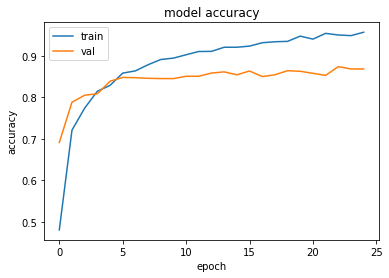

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


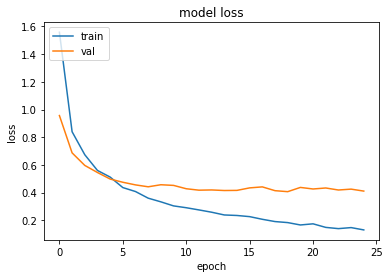

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



In [ ]:
loss, acc = model.evaluate(X_test,y_test)
loss1, acc1 = model.evaluate(X_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)


104/104 [==============================] - 57s 542ms/step - loss: 0.0712 - accuracy: 0.9853
Test loss: 0.41121089458465576    Test accuracy: 0.8680701851844788
Train loss: 0.07118132710456848    Train accuracy: 0.9852631688117981


### MobileNetV2

In [ ]:
from keras.applications import MobileNetV2
# Instantiate a DenseNet121 model with pre-trained weights
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False


9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [ ]:
# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Add a fully connected layer
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)


# Add a logistic layer
predictions = Dense(12, activation='softmax')(x)
x = Dropout(0.5)(x)


# This is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)


In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_7[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [ ]:
# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.save('MobileNetV2_0129.h5')


print(os.path.getsize("MobileNetV2_0129.h5")/1048576, "MB")


14.125572204589844 MB


In [ ]:
# Train the model

history=model.fit(X_train, y_train , epochs=25, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/25
52/52 [==============================] - 32s 557ms/step - loss: 1.4278 - accuracy: 0.5398 - val_loss: 0.7972 - val_accuracy: 0.7291
Epoch 2/25
52/52 [==============================] - 27s 526ms/step - loss: 0.7095 - accuracy: 0.7723 - val_loss: 0.6234 - val_accuracy: 0.7965
Epoch 3/25
52/52 [==============================] - 27s 529ms/step - loss: 0.5674 - accuracy: 0.8006 - val_loss: 0.5012 - val_accuracy: 0.8260
Epoch 4/25
52/52 [==============================] - 27s 518ms/step - loss: 0.4821 - accuracy: 0.8376 - val_loss: 0.5124 - val_accuracy: 0.8239
Epoch 5/25
52/52 [==============================] - 27s 526ms/step - loss: 0.4016 - accuracy: 0.8595 - val_loss: 0.4685 - val_accuracy: 0.8456
Epoch 6/25
52/52 [==============================] - 26s 505ms/step - loss: 0.3632 - accuracy: 0.8731 - val_loss: 0.4325 - val_accuracy: 0.8533
Epoch 7/25
52/52 [==============================] - 26s 511ms/step - loss: 0.2928 - accuracy: 0.9041 - val_loss: 0.4387 - val_accuracy: 0.8421

In [ ]:
model.save('DenseNet121_other_0129.h5')


print(os.path.getsize("DenseNet121_other_0129.h5")/1048576, "MB")



24.23772430419922 MB


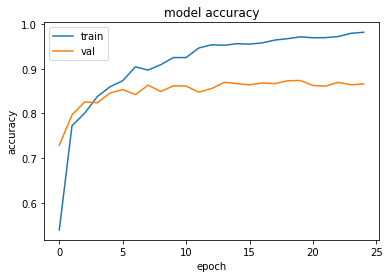

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()


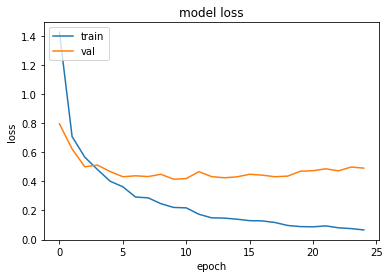

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()



In [ ]:
loss, acc = model.evaluate(X_test,y_test)
loss1, acc1 = model.evaluate(X_train,y_train)
print('Test loss:', loss,'   Test accuracy:', acc)
print('Train loss:', loss1,'   Train accuracy:',acc1)


104/104 [==============================] - 21s 206ms/step - loss: 0.0256 - accuracy: 0.9946
Test loss: 0.49174097180366516    Test accuracy: 0.8659648895263672
Train loss: 0.025565259158611298    Train accuracy: 0.9945864677429199


## **Predict train model**

In [ ]:
predictions = model.predict(X_test)

45/45 [==============================] - 10s 201ms/step


In [ ]:
def plot_image(i, predictions_array, true_label, img):
  true_label, img = np.argmax(true_label[i]), img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% \n({})".format(np.array(df.Name)[predicted_label],
                                100*np.max(predictions_array),
                                np.array(df.Name)[true_label]),
                                color=color)

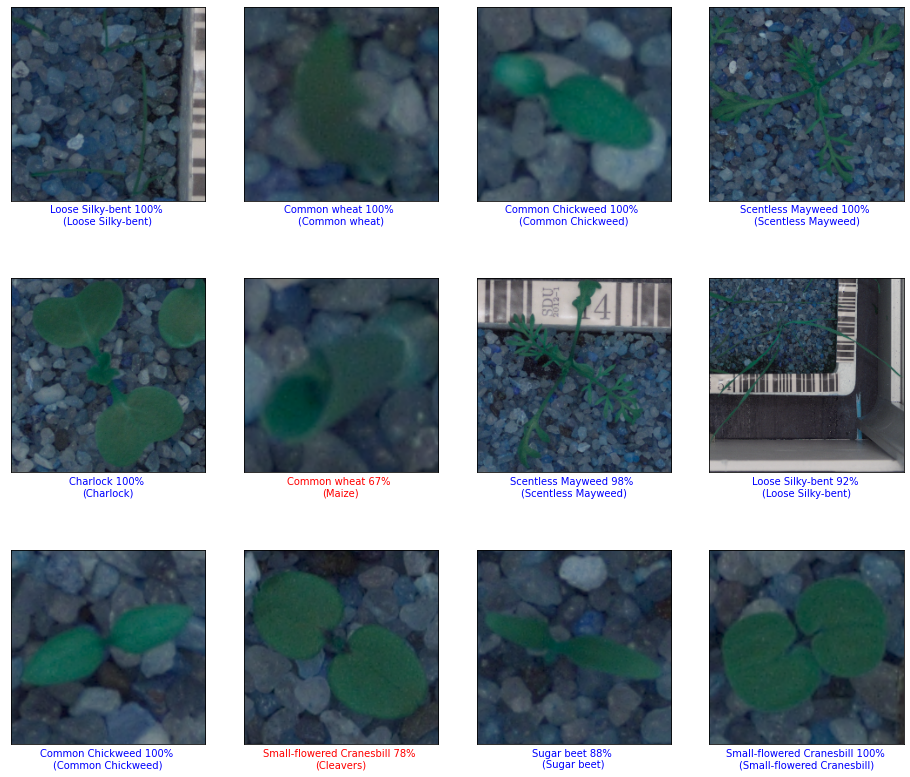

In [ ]:
fig=plt.figure(figsize=(16, 20))
rows, cols = 3,4
for i in range(0, cols*rows):
    fig.add_subplot(rows, cols, i+1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplots_adjust(hspace=-0.5)
plt.show()